<a href="https://colab.research.google.com/github/Raiyan01/HW1/blob/main/Ryan_Belo_PokemonClassification_CodeAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import zipfile
import os
from pathlib import Path
import re

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
# WARNING: this code is used to import dataset from kaggle 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#WARNING: this code is used while importing dataset from kaggle 
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#WARNING: this code is used while importing dataset from kaggle 
#changing the working directory
!kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

pokemon-images-and-types.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#WARNING: this code is used while importing dataset from kaggle 
#unzipping the zip files and deleting the zip files
!unzip \*.zip 

Archive:  pokemon-images-and-types.zip
replace images/images/abomasnow.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# create a path to the pokemon image directory
train_dir = 'images/images'
train_path = Path(train_dir)

# create a dataframe with the name and filepath of each pokemon
files = list(train_path.glob('*.png'))
names = [os.path.split(x)[1] for x in list(train_path.glob('*.png'))]
image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

# load in csv with the name, primary type, and secondary type of each pokemon
label_df = pd.read_csv('pokemon.csv')

# merge image_df with label_df
df = image_df.merge(label_df, on='Name')

# drop the Name and Type2 columns
df = df.drop(['Name', 'Type2'], axis=1) 
df.head()

,Filepath,Type1
0,images/images/abomasnow.png,Grass
1,images/images/azumarill.png,Water
2,images/images/bagon.png,Dragon
3,images/images/azelf.png,Psychic
4,images/images/azurill.png,Normal


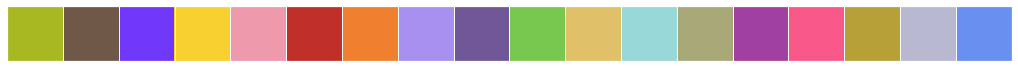

In [ ]:
custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0', 
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

sns.set(font_scale=1.25) 
sns.set_palette(sns.color_palette(custom_colors.values()))
sns.palplot(sns.color_palette(custom_colors.values()),size=1)

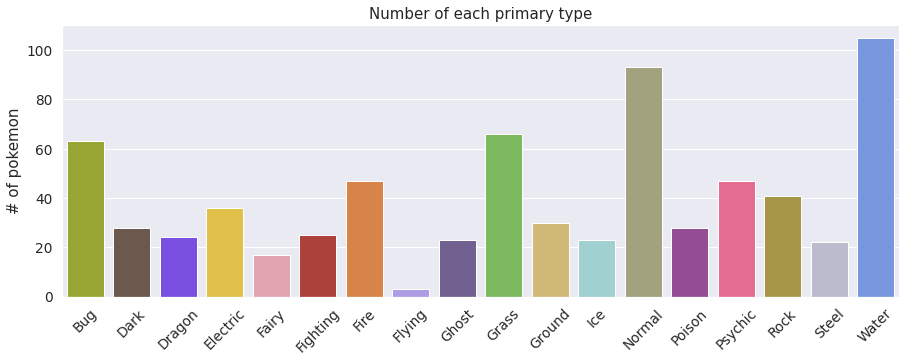

In [ ]:
# find the number of each type of pokemon 
type1 = list(custom_colors.keys())
type1_nums = []
for type in type1:
  type1_nums.append(sum(df['Type1']==type))

type1_data = pd.DataFrame(data=type1_nums, index=type1, columns=['# of pokemon'])

# plot number of each type of pokemon
plt.figure(figsize=(15,5))
plt.title('Number of each primary type')
ax = sns.barplot(x=type1_data.index, y='# of pokemon', data=type1_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

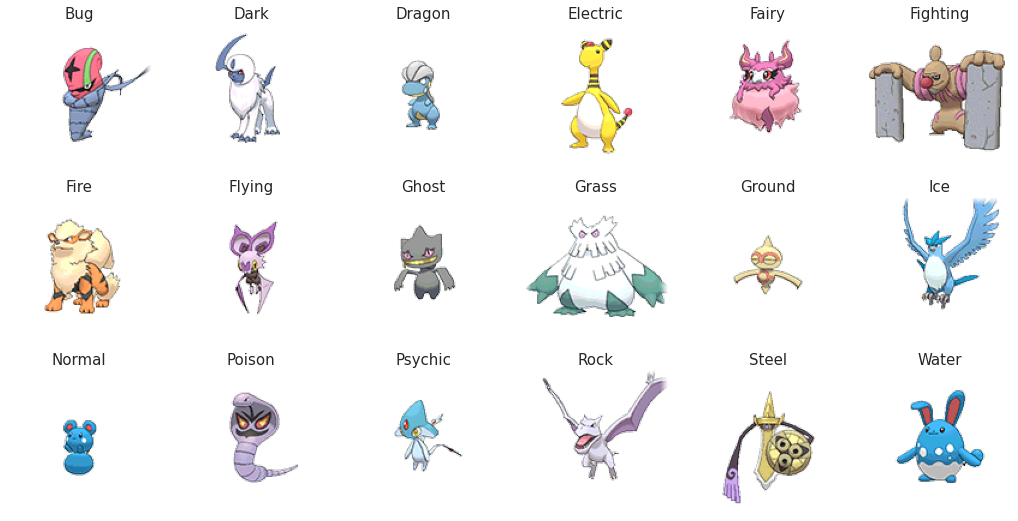

In [ ]:
# determine the indices of the first occurrance of each pokemon type
first_row_indices = []
for type in type1:
  first_row_indices.append(df[df['Type1']==type].index[0])

# obtain the image from the filepath at the determined indices
imgs = []
for index in first_row_indices:
  imgs.append(mpimg.imread(df.iat[index, 0]))

# output the images 
f, axarr = plt.subplots(3,6, figsize=(18,9))  
count = 0
for r in range(3):
  for c in range(6):
    axarr[r,c].imshow(imgs[count])
    axarr[r,c].set_title(type1[count])
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

In [ ]:
# limit data to fire and water types
df = df.query("Type1 == 'Water' | Type1 == 'Fire'")

print("Number of Water-types:", len(df[df['Type1'] == 'Water']))
print("Number of Fire-types:", len(df[df['Type1'] == 'Fire']))

Number of Water-types: 105
Number of Fire-types: 47


In [ ]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,   # split the dataset into a training set and a validation set in an 8:2 ratio
    rescale=1./255          # rescale the rgb values to fit between 0 and 1 
)


train_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='validation'
)

Found 122 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


In [ ]:
img_input = layers.Input(shape=(120, 120, 4))

x = layers.Conv2D(filters=64, kernel_size=(8, 8), activation='relu')(img_input)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=128, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=256, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=img_input, outputs=output)

model.compile(
    optimizer='adam',                 
    loss='binary_crossentropy',
    metrics=['acc', keras.metrics.AUC()]
)

# print model layers
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 4)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 113, 113, 64)      16448     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 17, 17, 256)       2097

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
4/4 [==============================] - 2s 221ms/step - loss: 3.4728 - acc: 0.4508 - auc_1: 0.4943 - val_loss: 0.6917 - val_acc: 0.6333 - val_auc_1: 0.4211 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 105ms/step - loss: 0.6645 - acc: 0.6967 - auc_1: 0.3668 - val_loss: 0.6679 - val_acc: 0.6333 - val_auc_1: 0.3254 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 98ms/step - loss: 0.6126 - acc: 0.7049 - auc_1: 0.5086 - val_loss: 0.6347 - val_acc: 0.6333 - val_auc_1: 0.8589 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 103ms/step - loss: 0.5500 - acc: 0.7049 - auc_1: 0.8194 - val_loss: 0.5884 - val_acc: 0.6333 - val_auc_1: 0.8923 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 1s 143ms/step - loss: 0.5231 - acc: 0.7049 - auc_1: 0.7952 - val_loss: 0.5021 - val_acc: 0.6333 - val_auc_1: 0.9856 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 1s 165ms/step - loss: 0.4493 - acc: 0.7131 - auc_1

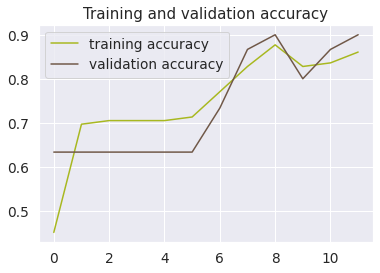

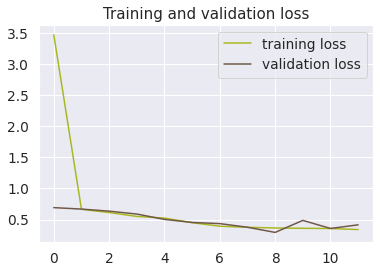

In [ ]:
# retrieve accuracy history on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']

# retrieve loss history on training and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

# get number of epochs
epochs = range(len(acc))

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
# get true labels
true_labels = val_data.labels

# get predictions in the form of probablities 
predictions = model.predict(val_data)

# convert probablities into binary values 
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

# determine filepaths of misclassified pokemon
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  misclassified_filepaths.append(val_data.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))

1/1 [==============================] - 0s 165ms/step
Model predictions: [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Actual labels:     [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
# of misclassified pokemon: 17


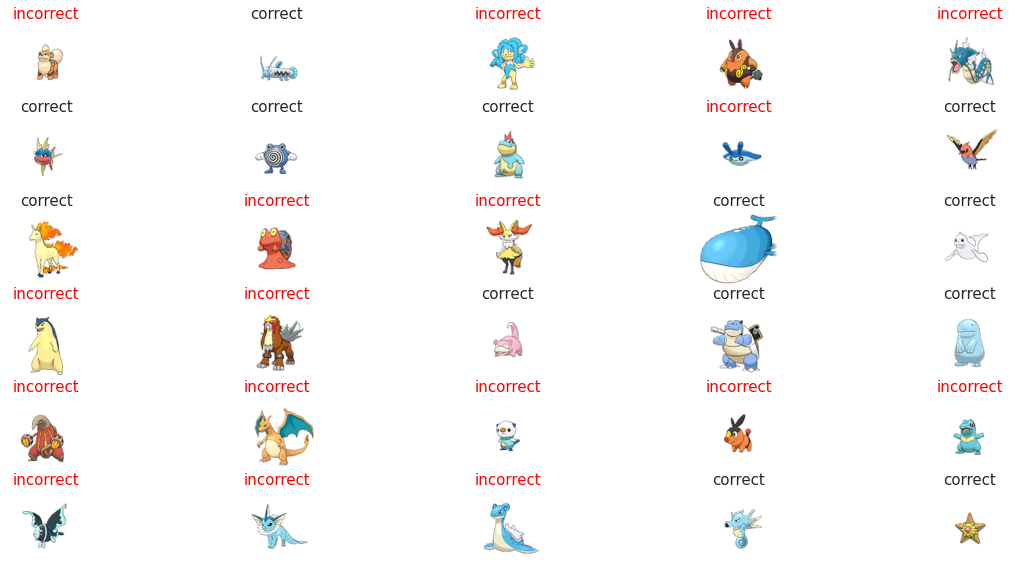

In [ ]:
# obtain the images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plot results
f, axarr = plt.subplots(6,5, figsize=(20,10))  
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()